In [1]:
import pandas as pd
import numpy as np
bank = pd.read_csv("E:\\Graduation_Project\\DiCE_XAI_codes\\results\\pre_bank.csv")

# 1️⃣ 划分类别型和数值型特征
categorical_features = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'poutcome'
]
numeric_features = [col for col in bank.columns if col not in categorical_features + ['y']]

In [2]:
from sklearn.preprocessing import LabelEncoder
features = list(bank.columns)
encoders = {}          # 保存每一列的 LabelEncoder

for f in categorical_features:
    le = LabelEncoder()
    bank[f] = le.fit_transform(bank[f])
    encoders[f] = le    # 留着以后解码

In [3]:
bank_decoded = bank.copy()
for f, le in encoders.items():
    bank_decoded[f] = le.inverse_transform(bank_decoded[f])

In [4]:
from dowhy import gcm
from dowhy.gcm import InvertibleStructuralCausalModel
import networkx as nx

import networkx as nx

graph = nx.DiGraph([
    # 人口与客户背景
    ('age', 'job'),
    ('education', 'job'),
    ('age', 'marital'),
    ('education', 'balance'),
    ('job', 'balance'),

    # 财务信用状况
    ('balance', 'housing'),
    ('balance', 'loan'),

    # 营销策略
    ('poutcome', 'contact'),
    ('contact', 'duration')

])
# 添加未建边但在图中的变量
graph.add_node('default')
graph.add_node('day')
graph.add_node('month')
graph.add_node('campaign')


causal_model = InvertibleStructuralCausalModel(graph)

summary = gcm.auto.assign_causal_mechanisms(causal_model, bank.drop(columns=['y']))
# 3. 拟合模型
gcm.fit(causal_model, bank.drop(columns=['y']))



d:\ANACONDA\envs\dice_XAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting causal mechanism of node campaign: 100%|██████████| 14/14 [00:00<00:00, 18.97it/s]


In [5]:
#print(summary)

注意这里使用的是反事实(gcm.counterfactual_samples)而不是干预(gcm.interventional_samples), 两者区别在于，后一个不在乎个体的区别，不会根据个体计算每个人具体的噪声而是用平均噪声替代计算传播影响，后者会对个体样本归因(计算他单独的噪声)，然后固定其他变量，改动想要的变量，生成个体级别的反事实结果。

In [6]:

cf = gcm.counterfactual_samples(
    causal_model,
    {'education': lambda x: 1},   # 保证 shape 相同
    observed_data=bank[:1]
)[bank.drop(columns=['y']).columns]


In [7]:
print(bank[:1])
print(cf)

   age  job  marital  education  default  balance  housing  loan  contact  \
0   39    4        0          2        0      517        1     1        2   

   day  month  duration  campaign  poutcome  y  
0   14      8      1328         1         3  1  
   age  job  marital  education  default  balance  housing  loan  contact  \
0   39    3        0          1        0     -349        2     1        2   

   day  month  duration  campaign  poutcome  
0   14      8      1328         1         3  


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import time

def set_seed(s=0):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
set_seed(1)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [9]:
import dice_ml
from dice_ml.utils.helpers import DataTransfomer
transformer = DataTransfomer(func='ohe-min-max')

target = bank['y']
train_dataset, test_dataset, y_train, y_test = train_test_split(bank, 
                                                                target,
                                                                test_size=0.2, 
                                                                random_state=42, 
                                                                stratify=bank['y'])

X_train_df = train_dataset.drop('y', axis=1)
X_test_df = test_dataset.drop('y', axis=1)
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=numeric_features,
                 outcome_name='y')
# 2. 绑定 data_interface，用于定义哪些列是连续/类别/目标变量等
transformer.feed_data_params(d)
# ✅ 3. 初始化转换器（这是你漏掉的步骤！）
transformer.initialize_transform_func()

X_train = transformer.transform(X_train_df)
X_test = transformer.transform(X_test_df)

In [10]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

def build_simple_dnn():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, activation='relu', input_shape=(49,)))  # 输入31维特征
    model.add(keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model



model = build_simple_dnn()

model.load_weights('my_model_weights_bank.h5')   # 加载之前保存的权重

In [11]:
# 预测（以X_test为例）
y_pred_prob = model.predict(X_test)

# 概率转类别
y_pred = y_pred_prob.argmax(axis=1)

# 计算准确率
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.3f}')

67/67 [==============================] - 0s 559us/step
Accuracy: 0.637


In [12]:
import dice_ml

# Using sklearn backend
m = dice_ml.Model(model=model, 
                  backend="TF2", 
                  func="ohe-min-max")

In [13]:
d.categorical_feature_names

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [14]:
import importlib
import dice_causal_random

importlib.reload(dice_causal_random)


from dice_causal_random import CausalRandom


exp = CausalRandom(d, m, causal_model)
e1 = exp.generate_counterfactuals(
    X_test_df[:100],
    total_CFs=4,
    desired_class="opposite",
    features_to_vary = 'all',
    sample_size=500
)



  0%|          | 0/100 [00:00<?, ?it/s]

[{'campaign': 39.0}, {'duration': 1429.0}, {'contact': '1'}, {'contact': '0'}, {'balance': 34150.0}, {'loan': '1'}, {'job': '6'}, {'marital': '0'}, {'housing': '0'}, {'campaign': 63.0}, {'contact': '0'}, {'default': '0'}, {'campaign': 40.0}, {'age': 68.0}, {'marital': '2'}, {'contact': '0'}, {'balance': 58550.0}, {'default': '1'}, {'loan': '1'}, {'day': 23.0}, {'housing': '0'}, {'poutcome': '0'}, {'poutcome': '3'}, {'contact': '1'}, {'day': 24.0}, {'month': '9'}, {'default': '0'}, {'duration': 4603.0}, {'contact': '1'}, {'day': 27.0}, {'job': '1'}, {'marital': '1'}, {'loan': '0'}, {'education': '1'}, {'campaign': 7.0}, {'poutcome': '3'}, {'contact': '1'}, {'housing': '0'}, {'job': '1'}, {'housing': '0'}, {'campaign': 33.0}, {'job': '0'}, {'poutcome': '3'}, {'day': 14.0}, {'day': 7.0}, {'campaign': 25.0}, {'loan': '0'}, {'balance': -878.0}, {'poutcome': '2'}, {'contact': '0'}, {'loan': '1'}, {'month': '1'}, {'job': '11'}, {'month': '11'}, {'loan': '0'}, {'balance': -2944.0}, {'month': '

TypeError: unhashable type: 'dict'

In [ ]:
print(e1.cf_examples_list[0].intervention_log)
node1_1 = e1.cf_examples_list[0].intervention_log[0, 0][0]
for key in graph.successors(node1_1):
    print('successors of', node1_1, ':', key)
for key in graph.successors('age'):
    print('successors of', 'age', ':', key)

[[('duration', 94.0) ('balance', 51491.0)]
 [('age', 36.0) ('duration', 686.0)]
 [('duration', 152.0) ('age', 25.0)]
 [('duration', 2.0) ('month', '0')]]
successors of age : job
successors of age : marital


In [ ]:
e1.cf_examples_list[0].final_cfs_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,52,5,1,2,0,2269,0,0,2,20,6,94,1,3,0
1,36,5,1,2,0,2269,0,0,2,20,6,686,1,3,0
2,25,6,2,2,0,2125,0,0,2,20,6,152,1,3,0
3,52,5,1,2,0,2269,0,0,2,20,6,2,1,3,0


In [ ]:
print(causal_model.causal_mechanism('age'))

Empirical Distribution


C:\Users\a1227\AppData\Local\Temp\ipykernel_13268\2699350417.py:4: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.pydot_layout(graph, prog='dot')      # 否则用 pydot


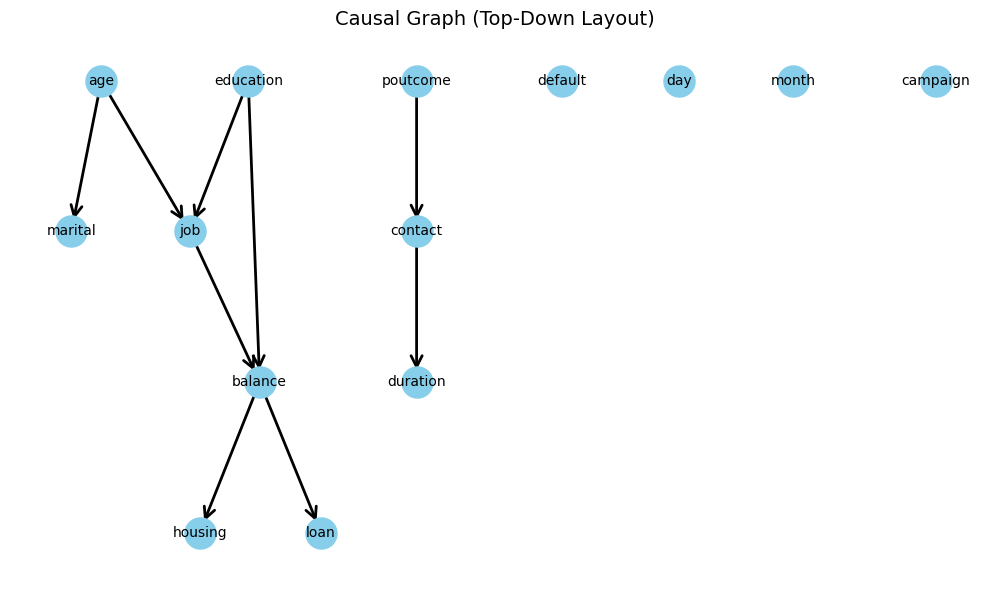

In [ ]:
# 可视化因果图
import matplotlib.pyplot as plt

pos = nx.nx_pydot.pydot_layout(graph, prog='dot')      # 否则用 pydot

plt.figure(figsize=(10, 6))

# 画节点
nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='skyblue')

# 画边（从上往下）
nx.draw_networkx_edges(
    graph, pos,
    arrows=True,
    arrowstyle='->',
    arrowsize=20,
    width=2
)

# 标签
nx.draw_networkx_labels(graph, pos, font_size=10)

plt.title("Causal Graph (Top-Down Layout)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def store_cfs(e1, length):
    list_cfs = []
    for i in range(length):
        orig_df = e1.cf_examples_list[i].test_instance_df.iloc[:, :-1].copy()
        cfs_df = e1.cf_examples_list[i].final_cfs_df.iloc[:, :-1].copy()
        for feature in orig_df.columns:
            orig_df[feature] = orig_df[feature].astype(bank[feature].dtype)
            cfs_df[feature] = cfs_df[feature].astype(bank[feature].dtype)
        list_cfs.append((
            orig_df,
            cfs_df
              ))
    return list_cfs



In [ ]:
from XAI_metrics import calc_valid, calc_sparsity, calc_continuous_proximity, \
    calc_categorical_proximity, calc_manifold_distance, calc_cf_num

cfs_causal = store_cfs(e1, 100)
valid_causal = calc_valid(cfs_causal, model, transformer)
sparsity_causal = calc_sparsity(cfs_causal, categorical_features)
con_proximity_causal = calc_continuous_proximity(cfs_causal, numeric_features)
cat_proximity_causal = calc_categorical_proximity(cfs_causal, categorical_features)
manifold_causal = calc_manifold_distance(cfs_causal, bank, categorical_features)
cf_num_causal = calc_cf_num(cfs_causal)

In [ ]:
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,39,4,0,2,0,517,1,1,2,14,8,1328,1,3,1
1,30,7,1,1,0,3929,1,0,0,20,9,593,1,3,1
2,46,4,0,2,0,624,0,0,0,18,7,420,1,1,1
3,32,0,1,2,0,653,0,0,0,2,6,84,1,3,1
4,36,1,1,0,0,319,1,0,0,13,8,774,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10573,24,4,1,1,0,867,1,0,2,20,6,546,10,3,1
10574,50,10,2,2,0,0,1,0,0,6,1,102,2,3,0
10575,42,0,0,1,0,153,1,0,2,16,8,844,1,3,1
10576,45,1,1,3,0,419,0,0,2,5,6,420,1,3,0


In [ ]:
print(valid_causal)
print(sparsity_causal)
print(con_proximity_causal)
print(cat_proximity_causal)
print(manifold_causal)
print(cf_num_causal)

1.0
0.2052215462454987
4.094355975641026
0.10416666666666669
722.6417621170413
4.0


In [ ]:
e1.cf_examples_list[0].test_instance_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,52,5,1,2,0,2269,0,0,2,20,6,1210,1,3,1


In [ ]:
e1.cf_examples_list[0].final_cfs_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,poutcome,y
0,52,5,1,2,0,2269,0,0,2,20,6,94,1,3,0
1,36,5,1,2,0,2269,0,0,2,20,6,686,1,3,0
2,25,6,2,2,0,2125,0,0,2,20,6,152,1,3,0
3,52,5,1,2,0,2269,0,0,2,20,6,2,1,3,0
